# COVID-19 v České republice

__TODO:__
- odečíst 12% pro opakovaně testované
- ~~přidat sem denní data z druhého notebooku~~
- ~~zobrazovat grafy v mřížce 2 x 2~~
- ~~jak zobrazovat datum u grafů, které kreslím Matplotlibem?~~
- ~~udělat grafy vývoje aktivních případů (protože sbírám data o uzdravených a úmrtí)~~
- zobrazovat denní poměr testovaných pozitivně/testovaných celkem a jeho vývoj


Na Raspi:
- ~~sbírat i základní data pro tento notebook s apify a mít tam vždy aktuální v ejdnom souboru (historii asi zachovat)~~
- možná by se některé dopočty na datech mohly dělat na Raspi a ne v notebooku tady


In [43]:
!scp pi@192.168.1.29:/home/pi/covid/daily_data.csv .
!scp pi@192.168.1.29:/home/pi/covid/total_positive_tests.csv .
!scp pi@192.168.1.29:/home/pi/covid/number_of_tested.csv .
!scp pi@192.168.1.29:/home/pi/covid/infected_by_region.csv .
!scp pi@192.168.1.29:/home/pi/covid/infected_daily.csv .


daily_data.csv                                100% 1224   169.8KB/s   00:00    
total_positive_tests.csv                      100% 1217   247.3KB/s   00:00    
number_of_tested.csv                          100% 1328   246.3KB/s   00:00    
infected_by_region.csv                        100%  335    63.7KB/s   00:00    
infected_daily.csv                            100% 1175   239.7KB/s   00:00    


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
import urllib.request
import json

with urllib.request.urlopen("https://api.apify.com/v2/key-value-stores/K373S4uCFR9W1K8ei/records/LATEST?disableRedirect=true") as url:
    data = json.loads(url.read().decode())
    

totalPositiveTests = pd.DataFrame(data['totalPositiveTests'])
totalPositiveTests['date'] = pd.to_datetime(totalPositiveTests['date'], errors='coerce')
totalPositiveTests['date'] = totalPositiveTests['date'].dt.date
#totalPositiveTests = pd.read_csv('total_positive_tests.csv')

numberOfTested = pd.DataFrame(data['numberOfTestedGraph'])
numberOfTested['date'] = pd.to_datetime(numberOfTested['date'], errors='coerce')
numberOfTested['date'] = numberOfTested['date'].dt.date
#numberOfTested = pd.read_csv('number_of_tested.csv')

infectedByRegion = pd.DataFrame(data['infectedByRegion'])
#infectedByRegion = pd.read_csv('infected_by_region.csv')
infectedByRegion.set_index('name', inplace = True) 


infectedDaily = pd.DataFrame(data['infectedDaily'])  
infectedDaily['date'] = pd.to_datetime(infectedDaily['date'], errors='coerce')
infectedDaily['date'] = infectedDaily['date'].dt.date
#infectedDaily = pd.read_csv('infected_daily.csv')

daily = pd.read_csv('daily_data.csv')    


#plt.style.use('bmh')
plt.style.use('ggplot')

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
import urllib.request
import json


totalPositiveTests = pd.read_csv('total_positive_tests.csv')

numberOfTested = pd.read_csv('number_of_tested.csv')

infectedByRegion = pd.read_csv('infected_by_region.csv')
infectedByRegion.set_index('name', inplace = True) 

infectedDaily = pd.read_csv('infected_daily.csv')

daily = pd.read_csv('daily_data.csv')    


plt.style.use('ggplot')

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## Základní data

In [12]:
#print(f'Celkový počet testovaných: {data["totalTested"]}')
#print(f'Celkový počet pozitivně testovaných: {data["infected"]}')
#print(f'Celkový počet aktivních případů: {data["infected"]-data["recovered"]-data["deceased"]}')
#print(f'Celkový počet vyléčených: {data["recovered"]}')
#print(f'Celkový počet mrtvých: {data["deceased"]}')

## Vývoj počtu pozitivně testovaných

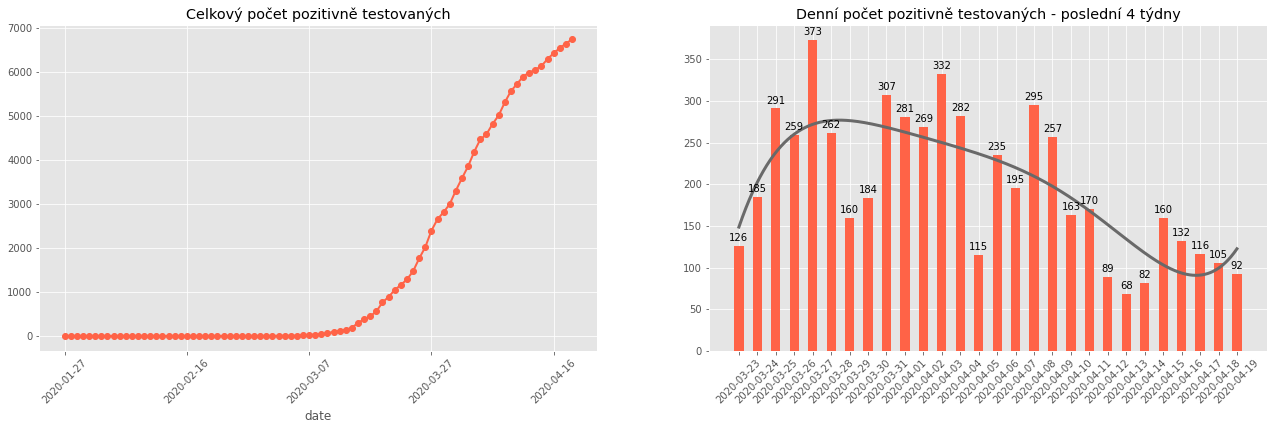

In [13]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

totalPositiveTests.plot(x='date', 
                        y='value', 
                        kind='line', 
                        style='tomato',
                        marker='o',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(infectedDaily.iloc[-days_back:, 1]) #.index) #daily['date']
y = np.array(infectedDaily.iloc[-days_back:, 0]) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet pozitivně testovaných - poslední 4 týdny')

plt.show()

In [14]:
# count daily tested cases (included repeated tests)
numberOfTested['daily'] = numberOfTested['value'] - numberOfTested['value'].shift(1)
# count growth factor 
infectedDaily['growthFactor'] = infectedDaily['value'] / infectedDaily['value'].shift(1)
infectedDaily['ones'] = 1

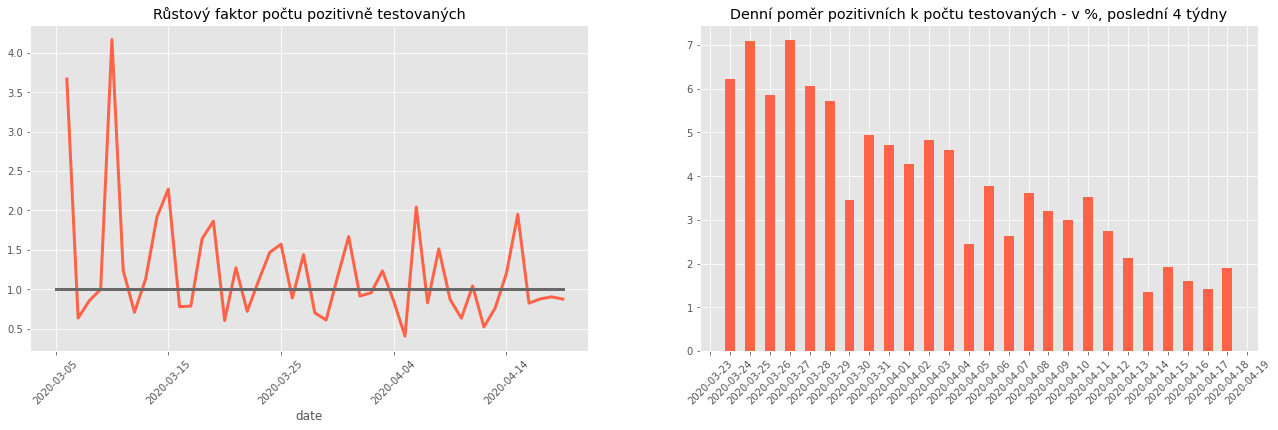

In [15]:
# interpoolace křivkou

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

infectedDaily[38:].plot(x='date', 
                    y=['growthFactor','ones'], 
                    kind='line',
                    style=['tomato', 'dimgray'],
                    linewidth=3,
                    #marker=['o',],
                    grid=True, 
                    legend=False,
                    ax=ax1,                        
                    title='Růstový faktor počtu pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

x = np.arange(days_back)
x_labels = np.array(infectedDaily.iloc[-days_back:, 1]) #.index) #daily['date']
y = np.array(100*(infectedDaily.iloc[-days_back+1:-1, 0]  / numberOfTested.iloc[-days_back:, 2])) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

#rects1 = ax2.bar(x, y, color='red')

ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
#autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní poměr pozitivních k počtu testovaných - v %, poslední 4 týdny')
plt.show()

## Vývoj počtu testovaných

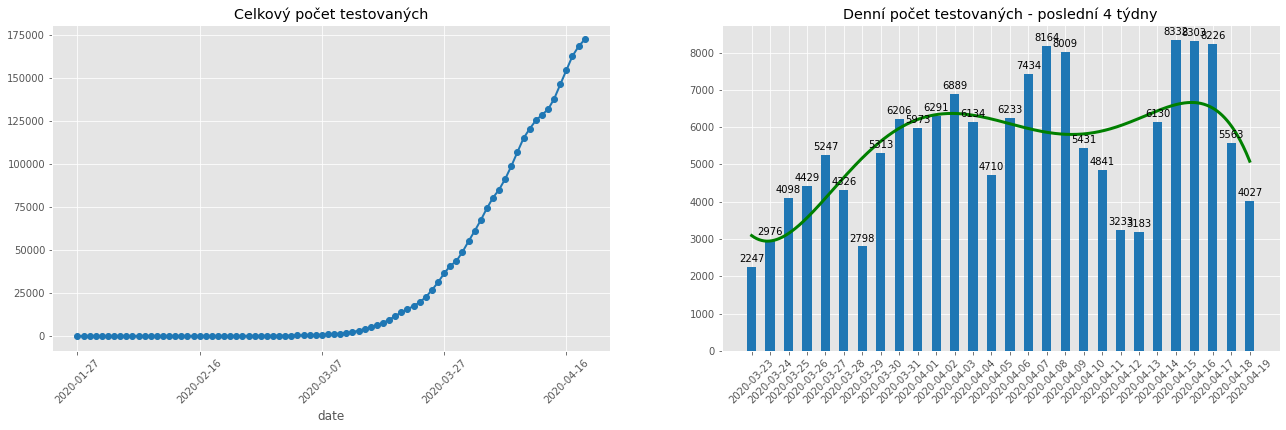

In [16]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

numberOfTested.plot(x='date', 
                        y='value', 
                        kind='line', 
                        style='tab:blue',
                        marker='o',
                        #color='royalblue',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(numberOfTested.iloc[-days_back:, 1]) #.index) #daily['date']
y = np.array(numberOfTested.iloc[-days_back:, 2]) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tab:blue')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'g-', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet testovaných - poslední 4 týdny')

plt.show()

## Vývoj průměrného denního nárůstu pozitivně testovaných 

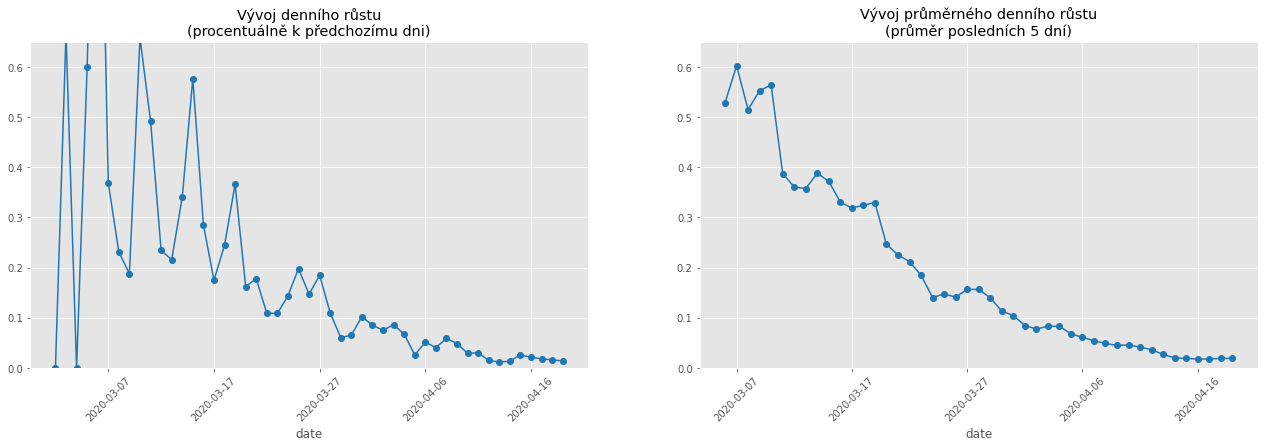

In [17]:
totalPositiveTests['increase']=0
df = totalPositiveTests
totalPositiveTests['increase'] = (totalPositiveTests['value'] - \
                                  totalPositiveTests['value'].shift(1)) / \
                                  totalPositiveTests['value'].shift(1)
totalPositiveTests['increase5days'] = (totalPositiveTests['increase'] + \
                                       totalPositiveTests['increase'].shift(1) + \
                                       totalPositiveTests['increase'].shift(2) + \
                                       totalPositiveTests['increase'].shift(3) + \
                                       totalPositiveTests['increase'].shift(4)) / 5
#totalPositiveTests.tail()

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date',
             y='increase', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax1,
             title='Vývoj denního růstu\n(procentuálně k předchozímu dni)')
ax1.tick_params(axis="x", rotation=45) 

df.plot(x='date',
             y='increase5days', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax2,
             title='Vývoj průměrného denního růstu\n(průměr posledních 5 dní)')
ax2.tick_params(axis="x", rotation=45) 


plt.show()


# Počty uzdravených a zemřelých

Poslední den 2020-04-20 (neúplná data): 13 uzdravených, 2 zemřelých


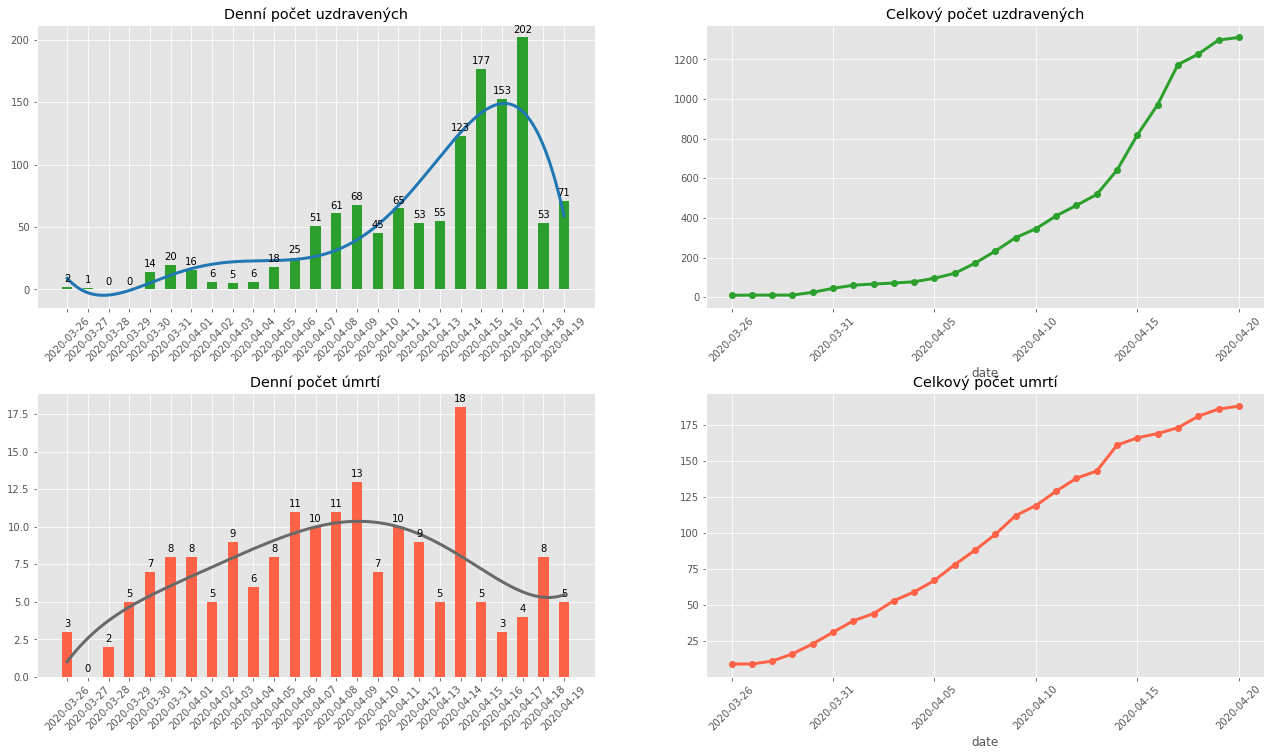

In [18]:
print(f'Poslední den {daily.iloc[-1, 0]} (neúplná data): {daily.iloc[-1,6]} uzdravených, {daily.iloc[-1,8]} zemřelých')
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = np.arange(len(daily)-1)
x_labels = np.array(daily.iloc[:-1,0]) #.index) #daily['date']
y = np.array(daily.iloc[:-1, 6]) ## 'recovered' -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title('Denní počet uzdravených')
plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalRecovered', 
            kind='line',
            linewidth=3,
            style='tab:green',
            marker='o',
            grid=True, 
            legend=False,
            ax=ax2,
            title='Celkový počet uzdravených')
ax2.tick_params(axis="x", rotation=45)

x = np.arange(len(daily)-1)
x_labels = np.array(daily.iloc[:-1, 0]) #.index) #daily['date']
y = np.array(daily.iloc[:-1, 8]) ## deceased bez posledního dne (neúplná data)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax3.bar(x, y, width=.5, color='tomato')
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax3)

ax3.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax3.set_title('Denní počet úmrtí')
#plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalDeceased', 
            kind='line',
            linewidth=3,
            style='tomato',
            marker='o',
            grid=True,
            legend=False,
            ax=ax4,
            title='Celkový počet umrtí')
ax4.tick_params(axis="x", rotation=45)

plt.show()

Poslední den 2020-04-20 (neúplná data): 13 uzdravených, 2 zemřelých


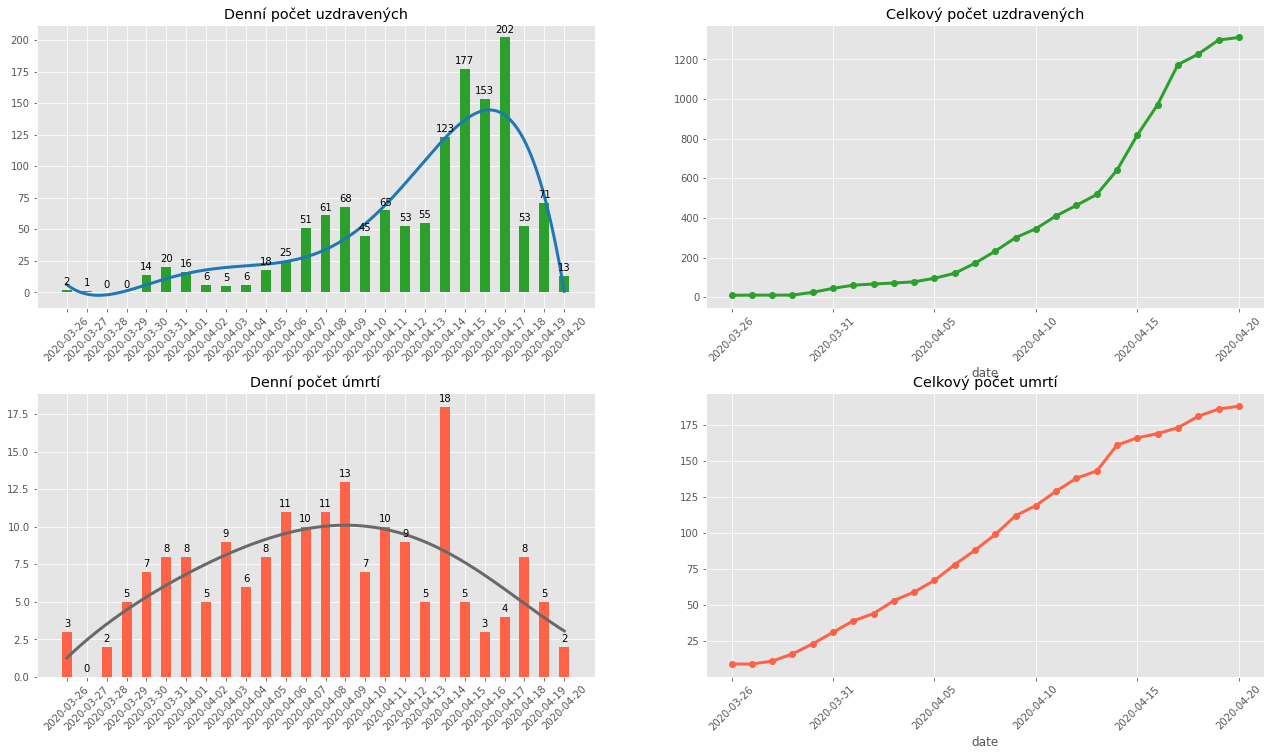

In [19]:
print(f'Poslední den {daily.iloc[-1, 0]} (neúplná data): {daily.iloc[-1,6]} uzdravených, {daily.iloc[-1,8]} zemřelých')
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = np.arange(len(daily))
x_labels = np.array(daily.iloc[:,0]) #.index) #daily['date']
y = np.array(daily.iloc[:, 6]) ## 'recovered' -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title('Denní počet uzdravených')
plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalRecovered', 
            kind='line',
            linewidth=3,
            style='tab:green',
            marker='o',
            grid=True, 
            legend=False,
            ax=ax2,
            title='Celkový počet uzdravených')
ax2.tick_params(axis="x", rotation=45)

x = np.arange(len(daily))
x_labels = np.array(daily.iloc[:, 0]) #.index) #daily['date']
y = np.array(daily.iloc[:, 8]) ## deceased bez posledního dne (neúplná data)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax3.bar(x, y, width=.5, color='tomato')
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax3)

ax3.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax3.set_title('Denní počet úmrtí')
#plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalDeceased', 
            kind='line',
            linewidth=3,
            style='tomato',
            marker='o',
            grid=True,
            legend=False,
            ax=ax4,
            title='Celkový počet umrtí')
ax4.tick_params(axis="x", rotation=45)

plt.show()

# Celkový počet pozitivně testovaných vs. aktivní případy

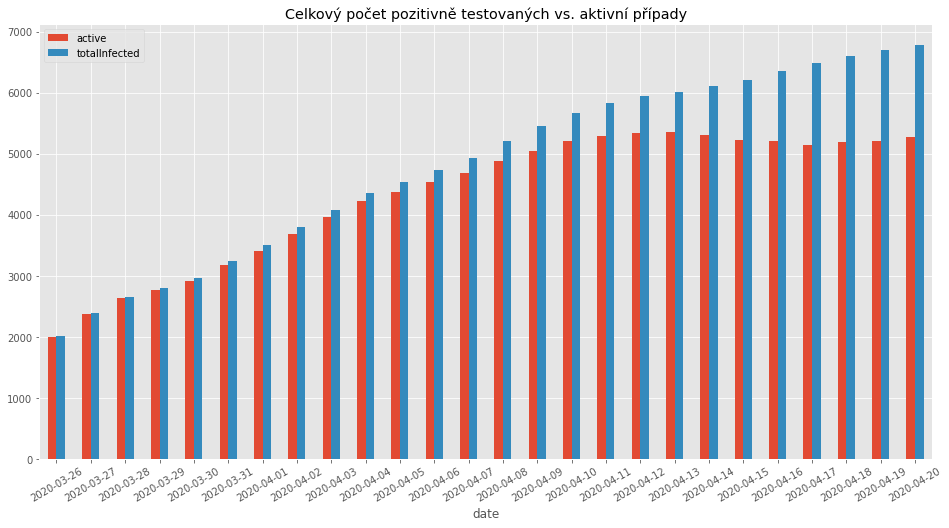

In [20]:
daily['active'] = daily['totalInfected'] - daily['totalRecovered'] - daily['totalDeceased'] 

daily.plot(x='date', 
            y=['active', 'totalInfected'], 
            kind='bar', 
            #style='r+-',
            figsize=(16, 8),
            grid=True, 
            title='Celkový počet pozitivně testovaných vs. aktivní případy')
plt.xticks(rotation=30)
plt.show()

# Počet infikovaných podle krajů

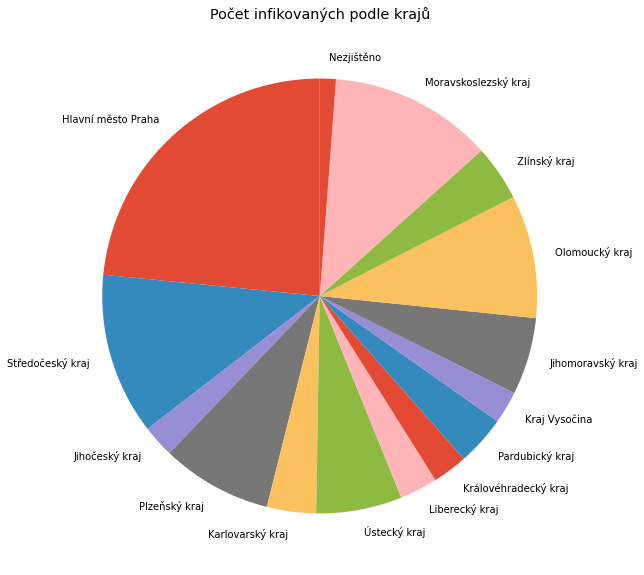

In [22]:
infectedByRegion.plot.pie(y='value', 
                          figsize=(10, 10), 
                          startangle=90, 
                          title="Počet infikovaných podle krajů", 
                          legend=False, 
                          label='')
plt.show()

In [41]:
infectedByRegion

,value,ratio,citizens,county_ratio
name,,,,
Hlavní město Praha,1591,0.235843,1309000.0,0.001215
Středočeský kraj,816,0.120961,1369000.0,0.000596
Jihočeský kraj,162,0.024014,642000.0,0.000252
Plzeňský kraj,559,0.082864,585000.0,0.000956
Karlovarský kraj,248,0.036763,295000.0,0.000841
Ústecký kraj,433,0.064186,821000.0,0.000527
Liberecký kraj,191,0.028313,442000.0,0.000432
Královéhradecký kraj,176,0.026090,551000.0,0.000319
Pardubický kraj,251,0.037207,520000.0,0.000483


In [31]:
infectedByRegion['ratio'] = infectedByRegion.loc[:, 'value'] / totalPositiveTests.iloc[-1,0]

In [40]:
infectedByRegion['county_ratio'] = infectedByRegion.loc[:, 'value'] / infectedByRegion.loc[:, 'citizens']

In [30]:
infectedByRegion.loc[:,'value']

name
Hlavní město Praha      1591
Středočeský kraj         816
Jihočeský kraj           162
Plzeňský kraj            559
Karlovarský kraj         248
Ústecký kraj             433
Liberecký kraj           191
Královéhradecký kraj     176
Pardubický kraj          251
Kraj Vysočina            163
Jihomoravský kraj        390
Olomoucký kraj           621
Zlínský kraj             281
Moravskoslezský kraj     824
Nezjištěno                81
Name: value, dtype: int64

In [34]:
infectedByRegion.sort_values(by=['ratio'], ascending=False)

,value,ratio
name,,
Hlavní město Praha,1591,0.235843
Moravskoslezský kraj,824,0.122146
Středočeský kraj,816,0.120961
Olomoucký kraj,621,0.092055
Plzeňský kraj,559,0.082864
Ústecký kraj,433,0.064186
Jihomoravský kraj,390,0.057812
Zlínský kraj,281,0.041654
Pardubický kraj,251,0.037207


In [42]:
infectedByRegion.sort_values(by=['county_ratio'], ascending=False)

,value,ratio,citizens,county_ratio
name,,,,
Hlavní město Praha,1591,0.235843,1309000.0,0.001215
Olomoucký kraj,621,0.092055,633000.0,0.000981
Plzeňský kraj,559,0.082864,585000.0,0.000956
Karlovarský kraj,248,0.036763,295000.0,0.000841
Moravskoslezský kraj,824,0.122146,1203000.0,0.000685
Středočeský kraj,816,0.120961,1369000.0,0.000596
Ústecký kraj,433,0.064186,821000.0,0.000527
Pardubický kraj,251,0.037207,520000.0,0.000483
Zlínský kraj,281,0.041654,583000.0,0.000482


In [38]:

infectedByRegion.loc['Hlavní město Praha', 'citizens'] = 1309000
infectedByRegion.loc['Středočeský kraj', 'citizens'] = 1369000
infectedByRegion.loc['Jihočeský kraj', 'citizens'] = 642000
infectedByRegion.loc['Plzeňský kraj', 'citizens'] = 585000
infectedByRegion.loc['Karlovarský kraj', 'citizens'] = 295000
infectedByRegion.loc['Ústecký kraj', 'citizens'] = 821000
infectedByRegion.loc['Liberecký kraj', 'citizens'] = 442000
infectedByRegion.loc['Královéhradecký kraj', 'citizens'] = 551000
infectedByRegion.loc['Pardubický kraj', 'citizens'] = 520000
infectedByRegion.loc['Kraj Vysočina', 'citizens'] = 509000
infectedByRegion.loc['Jihomoravský kraj', 'citizens'] = 1189000
infectedByRegion.loc['Olomoucký kraj', 'citizens'] = 633000
infectedByRegion.loc['Zlínský kraj', 'citizens'] = 583000 
infectedByRegion.loc['Moravskoslezský kraj', 'citizens'] = 1203000
infectedByRegion.loc['Nezjištěno', 'citizens'] = 200000
